In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from pushover import notify
from utils import makegif
from random import randint
import numpy as np

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
bs = 32 # batchsize

In [4]:
# Load Data
dataset = datasets.ImageFolder(root='trainings/roll_imgs_velo_partial', transform=transforms.Compose([
#     transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

(1339, 42)

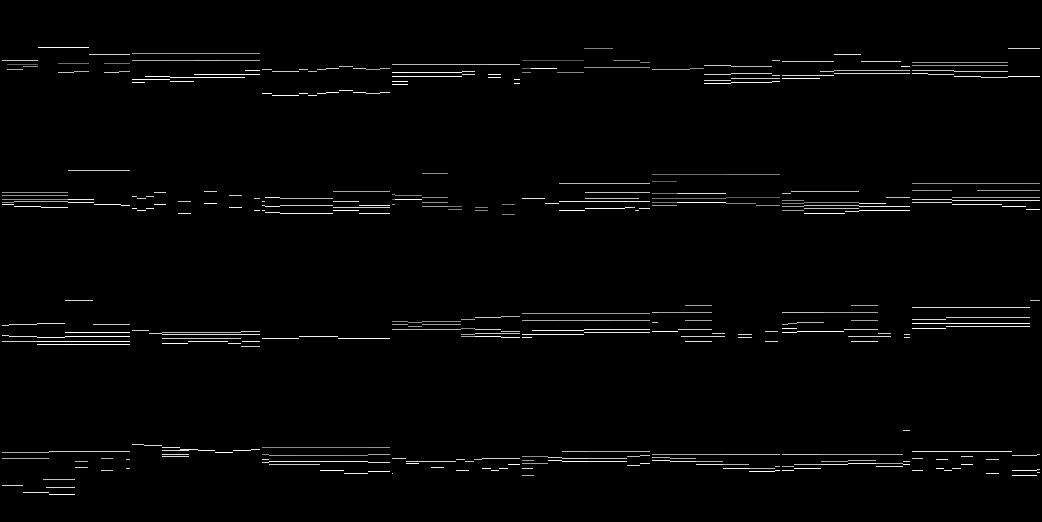

In [5]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))


save_image(fixed_x, 'tmp/real_image.png')

Image('tmp/real_image.png')

In [6]:
print(dataset[1][0].shape)
HSIZE = 2048 #9216 # 1024
ZDIM =  32

torch.Size([3, 128, 128])


In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
class UnFlatten(nn.Module):
    def forward(self, input, size=HSIZE):
        return input.view(input.size(0), size, 1, 1)

In [9]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=HSIZE, z_dim=ZDIM):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2), # -> [32, 32, 31, 31] 63
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # -> [32, 64, 14, 14] 31
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2), # -> [32, 128, 6, 6] 14
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2), # -> [32, 256, 2, 2] 6
            nn.ReLU(), 
            nn.Conv2d(256, 512, kernel_size=4, stride=2), # -> Null -> [32, 512, 2, 2] 
            nn.ReLU(), 
            Flatten() # -> [32, 1024]  -> [32, 2048]
            # [32, a, b, c] -> [32, abc]
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(), 
            nn.ConvTranspose2d(h_dim, 256 , kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
#         self.decoder = nn.Sequential(
#             UnFlatten(),
#             nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
#             nn.Sigmoid(),
#         )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
#         print("bottle: ",mu.shape, logvar.shape)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
#         print("======== Encode ========", x.shape)
        h = self.encoder(x)
#         print("enc(x): ", h.shape)
        z, mu, logvar = self.bottleneck(h)
#         print("z.shape: ", z.shape)
        return z, mu, logvar

    def decode(self, z):
#         print("======== Decode ========", z.shape)
        z = self.fc3(z)
#         print("fc3(z).shape: ", z.shape)
        z = self.decoder(z)
#         print("decode(fc3(z)).shape: ", z.shape)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
#         print(z.shape)
        z = self.decode(z)
#         print(z.shape, mu.shape, logvar.shape)
        return z, mu, logvar

In [10]:
image_channels = fixed_x.size(1)

In [11]:
model = VAE(image_channels=image_channels).to(device)
model_version = "velo-alb-nimgs_1339-epochs_50" #"alb-nimgs_4312-epochs_50" #"AC-nimgs_2515-epochs_50" vae.torch-alb-nimgs_4312-epochs_50
model.load_state_dict(torch.load('models/vae.torch-' + model_version, map_location='cpu'))

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
epochs = 50

In [14]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

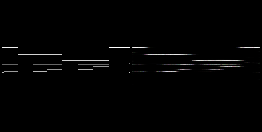

In [15]:
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
fixed_x2 = fixed_x.clone()

compare_x = compare(fixed_x)

sample_filename = 'outputs/sample_image-{}.png'.format(model_version)
save_image(compare_x.data.cpu(), sample_filename)
display(Image(sample_filename, width=300, unconfined=True))

In [ ]:
save_image(fixed_x2, 'tmp/test.png', padding=0)
display(Image('tmp/test.png'))
z, mu, log_var = model.encode(fixed_x2)